# Time Series Analysis & Forecasting on Microsoft Stock

## Import Libraries

In [1]:
import yfinance
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install pandas_market_calendars
import pandas_market_calendars as mcal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.2/211.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: toolz
    Found existing installation: toolz 0.12.1
    Uninstalling toolz-0.12.1:
      Successfully uninstalled toolz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.1.0 which is incompatible.


## Load and inspect data

In [3]:
stock = yfinance.download('MSFT', start=dt.datetime(2025, 1, 1))
stock.head()

/tmp/ipython-input-3812197097.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock = yfinance.download('MSFT', start=dt.datetime(2025, 1, 1))
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2025-01-02,415.514832,422.950005,411.812165,422.413951,16896500
2025-01-03,420.249908,420.924922,416.467811,417.996512,16662900
2025-01-06,424.716980,431.139603,422.364340,424.865876,20573600
2025-01-07,419.277069,427.496435,417.718559,425.858524,18139100
2025-01-08,421.451019,423.843375,418.453145,420.359068,15054600


In [4]:
stock.columns = ["_".join(col) for col in stock.columns]
stock = stock.reset_index()
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         270 non-null    datetime64[ns]
 1   Close_MSFT   270 non-null    float64       
 2   High_MSFT    270 non-null    float64       
 3   Low_MSFT     270 non-null    float64       
 4   Open_MSFT    270 non-null    float64       
 5   Volume_MSFT  270 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 12.8 KB


Closing of the stock is considered as it may have lesser influence from external factors like microsoft public event, news, etc.

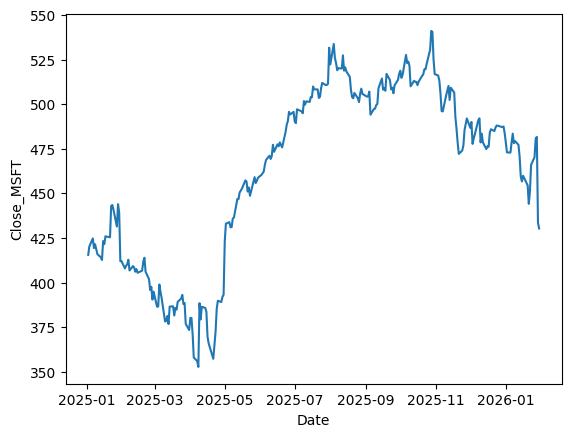

In [5]:
sns.lineplot(data=stock, x='Date', y='Close_MSFT');

In [6]:
# missing dates entries (all days - including holidays)
full_range = pd.date_range(
    start=stock.Date.min(),
    end=stock.Date.max(),
    freq="D"
)
missing_dates = full_range.difference(stock['Date'])
print(missing_dates)

DatetimeIndex(['2025-01-04', '2025-01-05', '2025-01-09', '2025-01-11',
               '2025-01-12', '2025-01-18', '2025-01-19', '2025-01-20',
               '2025-01-25', '2025-01-26',
               ...
               '2026-01-01', '2026-01-03', '2026-01-04', '2026-01-10',
               '2026-01-11', '2026-01-17', '2026-01-18', '2026-01-19',
               '2026-01-24', '2026-01-25'],
              dtype='datetime64[ns]', length=124, freq=None)


In [7]:
# missing dates entries (Mon-to-Fri business trading days)
business_range = pd.date_range(
    start=stock.Date.min(),
    end=stock.Date.max(),
    freq="B"   # Business day frequency
)
missing_dates = business_range.difference(stock['Date'])
print(missing_dates)

DatetimeIndex(['2025-01-09', '2025-01-20', '2025-02-17', '2025-04-18',
               '2025-05-26', '2025-06-19', '2025-07-04', '2025-09-01',
               '2025-11-27', '2025-12-25', '2026-01-01', '2026-01-19'],
              dtype='datetime64[ns]', freq=None)


In [8]:
nyse = mcal.get_calendar("NYSE") #NYSE/Nasdaq/US market holidays

schedule = nyse.schedule(
    start_date=stock.index.min(),
    end_date=stock.index.max()
)

valid_trading_days = schedule.index

missing_dates = valid_trading_days.difference(stock.index)
print(missing_dates)

DatetimeIndex([], dtype='datetime64[ns]', freq='C')


The missing dates are US business trading holidays like Independence Day.

In [9]:
# are dates in increasing order
print(stock.Date.is_monotonic_increasing)

True


In [10]:
stock.describe()

,Date,Close_MSFT,High_MSFT,Low_MSFT,Open_MSFT,Volume_MSFT
count,270,270.000000,270.000000,270.000000,270.000000,2.700000e+02
mean,2025-07-18 04:00:00,462.993504,466.869379,458.763075,462.971611,2.308269e+07
min,2025-01-02 00:00:00,352.669342,362.536513,342.951498,349.009021,5.855900e+06
25%,2025-04-10 06:00:00,419.520279,423.173347,415.522254,420.495577,1.668992e+07
50%,2025-07-19 12:00:00,477.595016,480.854996,472.978197,476.581620,2.075645e+07
75%,2025-10-22 18:00:00,506.010429,509.357784,502.102754,505.505971,2.534930e+07
max,2026-01-30 00:00:00,541.057373,553.502444,539.759814,553.283183,1.288553e+08
std,NaN,49.275610,49.177459,49.891468,49.907771,1.088375e+07


In [11]:
stock.Date.duplicated().sum()

np.int64(0)

In [12]:
# check daily movement
stock["Return"] = stock["Close_MSFT"].pct_change()
stock["Return"].describe()

,Return
count,269.000000
mean,0.000265
std,0.016453
min,-0.099931
25%,-0.007228
50%,0.000763
75%,0.006308
max,0.101337


### Daily Return Stats Summary
MSFT closing prices ranged from \$353 to \$541, with an average close around \$463.  
Trading volume averages ~23M shares per day, with occasional spikes above 100M, likely driven by major market events.

* Daily avg return is close to 0, as expected from stock data.
* Daily returns (std) show typical volatility around 1.6%, which is reasonable for a large-cap stock like MSFT.
* In extreme cases, the daily return is ~10%, which needs to be investigated further.

In [13]:
stock["Return"].abs().sort_values(ascending=False).head(10)

,Return
66,0.101337
268,0.099931
81,0.076254
18,0.061809
12,0.041307
143,0.039475
71,0.036606
63,0.035566
76,0.034483
44,0.033434


In [14]:
stock.loc[stock["Return"].abs().sort_values(ascending=False).head(5).index]

,Date,Close_MSFT,High_MSFT,Low_MSFT,Open_MSFT,Volume_MSFT,Return
66,2025-04-09,388.407776,391.133186,351.217167,351.654823,50199700,0.101337
268,2026-01-29,433.500000,442.500000,421.019989,439.989990,128855300,-0.099931
81,2025-05-01,423.131622,434.659817,422.634288,428.811166,58938100,0.076254
18,2025-01-30,411.951111,419.763476,410.134525,415.703430,54586300,-0.061809
12,2025-01-22,442.932617,443.994759,432.807297,434.355871,27803800,0.041307


### Extreme Return Days

The largest absolute daily returns are around ±10%, are driven by market events (earning announcement, recesion, major news), and not data errors(market correction).

* The price movement (Open ≈ 351, Low ≈ 351, Close ≈ 388) is internally consistent.
* The unusually large negative return (~−10%) on 2026-01-29 is accompanied by a trading volume (more trades, both buy and sell) of ~129 million shares. Whereas, the average daily volume is ~23 million shares. Such correlated events indicate market events and not data errors.

In [16]:
# high should be more than low for same date entry
(stock["High_MSFT"] < stock["Low_MSFT"]).sum()

np.int64(0)

In [17]:
#
((stock["Close_MSFT"] < stock["Low_MSFT"]) | (stock["Close_MSFT"] > stock["High_MSFT"])).sum()

np.int64(0)